# Hardware-Accelerated Video Decoding and Encoding

**Author**: [Moto Hira](moto@meta.com)

This tutorial shows how to use NVIDIA's hardware video decoder (NVDEC) and encoder (NVENC) with TorchAudio.

Using hardware encoder/decoder improves the speed of loading and saving certain types of videos. Using them in TorchAduio requires additional FFmpeg configuration. This tutorial goes over how to compile FFmpeg, and compare the speed it takes to process video.

**WARNING**

> This tutorial instsalls FFmpeg in system directory.
> If you run this tutorial on your system, please adjust the build configuration accordingly.

**NOTE**

> This tutorial was authored in Google Colab, and is tailored to Google Colab's specifications. Please check out this tutorial in [Google Colab](https://colab.research.google.com/drive/1DDah_IaGULEO66CfQWltRqaVheBkiXdN#sandboxMode=true).

To use NVENC/NVDEC with TorchAudio, the following items are required.

1. NVIDIA GPU with hardware video decoder/encoder.
2. FFmpeg libraries compiled with NVDEC/NVENC support. †
3. PyTorch / TorchAudio with CUDA support.

TorchAudio's official binary distributions are compiled with FFmpeg 4 libraries, and they contain the logic required for hardware-based decoding/encoding.

In the following sections, we build FFmpeg 4 libraries with NVDEC/NVENC support, then we demonstrate the performance imrovement using TorchAudio's `StreamReader`/`StreamWriter`.

† For details on NVDEC/NVENC and FFmpeg, please refer to the following articles.

* https://docs.nvidia.com/video-technologies/video-codec-sdk/nvdec-video-decoder-api-prog-guide/
* https://docs.nvidia.com/video-technologies/video-codec-sdk/ffmpeg-with-nvidia-gpu/#compiling-ffmpeg
* https://developer.nvidia.com/blog/nvidia-ffmpeg-transcoding-guide/


## Check the available GPU

In [1]:
!nvidia-smi

Fri Oct  7 13:01:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Update PyTorch and TorchAudio with nightly builds

Until TorchAudio 0.13 is released, we need to use the nightly builds of PyTorch and TorchAudio.

In [2]:
!pip uninstall -y -q torch torchaudio torchvision torchtext
!pip install --progress-bar off --pre torch torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu116 2> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cu116





## Build FFmpeg libraries with Nvidia NVDEC/NVENC support


### Install NVIDIA Video Codec Headers

To build FFmpeg with NVDEC/NVENC, we first install the headers that FFmpeg uses to interact with Video Codec SDK.

In [3]:
!git clone https://git.videolan.org/git/ffmpeg/nv-codec-headers.git
# Note: Google Colab's GPU has NVENC API ver 11.0, so we checkout 11.0 tag.
!cd nv-codec-headers && git checkout n11.0.10.1 && sudo make install

Cloning into 'nv-codec-headers'...
remote: Enumerating objects: 819, done.
remote: Counting objects: 100% (819/819), done.
remote: Compressing objects: 100% (697/697), done.
remote: Total 819 (delta 439), reused 0 (delta 0)
Receiving objects: 100% (819/819), 156.42 KiB | 410.00 KiB/s, done.
Resolving deltas: 100% (439/439), done.
Note: checking out 'n11.0.10.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 315ad74 add cuMemcpy
sed 's#@@PREFIX@@#/usr/local#' ffnvcodec.pc.in > ffnvcodec.pc
install -m 0755 -d '/usr/local/include/ffnvcodec'
install -m 0644 include/ffnvcodec/*.h '/usr/local/include/ffnvcodec'
install -m 075

### Download FFmpeg source code

Next we download the source code of FFmpeg 4. Any version later than 4.1 should work. We use 4.4.2 here.

In [4]:
!wget -q https://github.com/FFmpeg/FFmpeg/archive/refs/tags/n4.4.2.tar.gz
!tar -xf n4.4.2.tar.gz
!mv FFmpeg-n4.4.2 ffmpeg

### Install FFmpeg build and runtime dependencies

In the later test, we use H264 video codec and HTTPS protocol, so we install the libraries for them here.

In [5]:
!apt -qq update
!apt -qq install -y yasm libx264-dev libgnutls28-dev

STRIP	install-libavutil-shared

... Omitted for brevity ...

Setting up libx264-dev:amd64 (2:0.152.2854+gite9a5903-2) ...
Setting up yasm (1.3.0-2build1) ...
Setting up libunbound2:amd64 (1.6.7-1ubuntu2.5) ...
Setting up libp11-kit-dev:amd64 (0.23.9-2ubuntu0.1) ...
Setting up libtasn1-6-dev:amd64 (4.13-2) ...
Setting up libtasn1-doc (4.13-2) ...
Setting up libgnutlsxx28:amd64 (3.5.18-1ubuntu1.6) ...
Setting up libgnutls-dane0:amd64 (3.5.18-1ubuntu1.6) ...
Setting up libgnutls-openssl27:amd64 (3.5.18-1ubuntu1.6) ...
Setting up libgmpxx4ldbl:amd64 (2:6.1.2+dfsg-2) ...
Setting up libidn2-dev:amd64 (2.0.4-1.1ubuntu0.2) ...
Setting up libidn2-0-dev (2.0.4-1.1ubuntu0.2) ...
Setting up libgmp-dev:amd64 (2:6.1.2+dfsg-2) ...
Setting up nettle-dev:amd64 (3.4.1-0ubuntu0.18.04.1) ...
Setting up libgnutls28-dev:amd64 (3.5.18-1ubuntu1.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


### Configure FFmpeg build with Nvidia CUDA hardware support

Next we configure FFmpeg build. Note the following:

1. We provide flags like `-I/usr/local/cuda/include`, `-L/usr/local/cuda/lib64` to let the build process know where the CUDA libraries are found.
2. We provide flags like `--enable-nvdec` and `--enable-nvenc` to enable NVDEC/NVENC. Please check out the Transcoding Guide† for the detail.
3. We also provide NVCC flags with compute capability 37.   
This is because by default the configuration script verifies NVCC by compiling sample code targeting compute capability 30, which is too old for CUDA 11.
4. Many features are disabled to reduce the compilation time.
5. We install the library in `/usr/lib/`, which is one of the active search path of the dynamic loader.   
Doing so allows the resulting libraries to be found without requiring a restart of the current session. This might be an undesirable location, e.g. when one isn't using a disposable VM.

† NVIDIA FFmpeg Transcoding Guide https://developer.nvidia.com/blog/nvidia-ffmpeg-transcoding-guide/

In [6]:
# NOTE:
# When the configure script of FFmpeg 4 checks nvcc, it uses compute
# capability of 30 (3.0) by default. CUDA 11, however, does not support 
# compute capability 30.
# Here, we use 37, which is supported by CUDA 11 and both K80 and T4.
#
# Tesla K80: 37
# NVIDIA T4: 75

%env ccap=37

# NOTE:
# We disable most of the features to speed up compilation
# The necessary components are
# - demuxer: mov, aac
# - decoder: h264, h264_nvdec
# - muxer: mp4
# - encoder: libx264, h264_nvenc
# - gnutls (HTTPS)
#
# Additionally, we use FFmpeg's virtual input device to generate 
# test video data. This requires
# - input device: lavfi
# - filter: testsrc2
# - decoder: rawvideo
#

!cd ffmpeg && ./configure \
  --prefix='/usr/' \
  --extra-cflags='-I/usr/local/cuda/include' \
  --extra-ldflags='-L/usr/local/cuda/lib64' \
  --nvccflags="-gencode arch=compute_${ccap},code=sm_${ccap} -O2" \
  --disable-doc \
  --disable-static \
  --disable-bsfs \
  --disable-decoders \
  --disable-encoders \
  --disable-filters \
  --disable-demuxers \
  --disable-devices \
  --disable-muxers \
  --disable-parsers \
  --disable-postproc \
  --disable-protocols \
  --enable-decoder=aac \
  --enable-decoder=h264 \
  --enable-decoder=h264_cuvid \
  --enable-decoder=rawvideo \
  --enable-indev=lavfi \
  --enable-encoder=libx264 \
  --enable-encoder=h264_nvenc \
  --enable-demuxer=mov \
  --enable-muxer=mp4 \
  --enable-filter=scale \
  --enable-filter=testsrc2 \
  --enable-protocol=file \
  --enable-protocol=https \
  --enable-gnutls \
  --enable-shared \
  --enable-gpl \
  --enable-nonfree \
  --enable-cuda-nvcc \
  --enable-libx264 \
  --enable-nvenc \
  --enable-cuvid \
  --enable-nvdec

env: ccap=37
install prefix            /usr/
source path               .
C compiler                gcc
C library                 glibc
ARCH                      x86 (generic)
big-endian                no
runtime cpu detection     yes
standalone assembly       yes
x86 assembler             yasm
MMX enabled               yes
MMXEXT enabled            yes
3DNow! enabled            yes
3DNow! extended enabled   yes
SSE enabled               yes
SSSE3 enabled             yes
AESNI enabled             yes
AVX enabled               yes
AVX2 enabled              yes
AVX-512 enabled           yes
XOP enabled               yes
FMA3 enabled              yes
FMA4 enabled              yes
i686 features enabled     yes
CMOV is fast              yes
EBX available             yes
EBP available             yes
debug symbols             yes
strip symbols             yes
optimize for size         no
optimizations             yes
static                    no
shared                    yes
postprocessing su

### Build and install FFmpeg

In [7]:
!cd ffmpeg && make clean && make -j > /dev/null 2>&1
!cd ffmpeg && make install

INSTALL	libavdevice/libavdevice.so
INSTALL	libavfilter/libavfilter.so
INSTALL	libavformat/libavformat.so
INSTALL	libavcodec/libavcodec.so
INSTALL	libswresample/libswresample.so
INSTALL	libswscale/libswscale.so
INSTALL	libavutil/libavutil.so
INSTALL	install-progs-yes
INSTALL	ffmpeg
INSTALL	ffprobe


## Check FFmpeg installation

Let's do a quick sanity check to confirm that the FFmpeg we built works.

In [8]:
!ffprobe -hide_banner -decoders | grep h264

 VFS..D h264                 H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
 V..... h264_cuvid           Nvidia CUVID H264 decoder (codec h264)


In [9]:
!ffmpeg -hide_banner -encoders | grep 264

 V..... libx264              libx264 H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10 (codec h264)
 V....D h264_nvenc           NVIDIA NVENC H.264 encoder (codec h264)


The following command fetches video from remote server, decode with NVDEC (cuvid) and re-encode with NVENC. If this command does not work, then there is an issue with FFmpeg installation, and TorchAudio would not be able to use them either.

In [10]:
!ffmpeg -hide_banner -y -vsync 0 -hwaccel cuvid -hwaccel_output_format cuda -c:v h264_cuvid -resize 360x240 -i "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4" -c:a copy -c:v h264_nvenc -b:v 5M test.mp4

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 512
    compatible_brands: mp42iso2avc1mp41
    encoder         : Lavf58.76.100
  Duration: 00:03:26.04, start: 0.000000, bitrate: 1294 kb/s
  Stream #0:0(eng): Video: h264 (High) (avc1 / 0x31637661), yuv420p(tv, bt709), 960x540 [SAR 1:1 DAR 16:9], 1156 kb/s, 29.97 fps, 29.97 tbr, 30k tbn, 59.94 tbc (default)
    Metadata:
      handler_name    : ?Mainconcept Video Media Handler
      vendor_id       : [0][0][0][0]
  Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      handler_name    : #Mainconcept MP4 Sound Media Handler
      vendor_id       : [0][0][0][0]
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (h264_cuvid) -> h264 (h264_nvenc))
  Stream #0:1 -> #0:1 (copy)
Press

## Benchmarking GPU Encoding and Decoding

Now that FFmpeg and the resulting libraries are ready to use, we test NVDEC/NVENC with TorchAudio. For the basics of TorchAudio's streaming APIs, please refer to [Media I/O tutorials](https://pytorch.org/audio/main/tutorials.io.html).

**Note**

If you rebuild FFmpeg after importing torchaudio, you'll need to restart the session to activate the newly built FFmpeg libraries.

In [11]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

from torchaudio.io import StreamReader, StreamWriter

1.13.0.dev20221006+cu116
0.13.0.dev20221006+cu116


In [12]:
import time
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Benchmark NVDEC with `StreamReader`

First we test hardware decoding, and we fetch video from multiple locations (local file, network file, AWS S3) and use NVDEC to decod them.

In [13]:
!pip3 install --progress-bar off boto3 2> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [14]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

print(boto3.__version__)

1.24.88


In [15]:
!wget -q -O input.mp4 "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4"

First, we define the functions we'll use for testing.

Funcion `test_decode` decodes the given source from start to end, and it reports the elapsed time, and returns one image frmae as a sample.

In [16]:
result = torch.zeros((4, 2))
samples = [[None, None] for _ in range(4)]


def test_decode(src, config, i_sample):
  print("=" * 40)
  print("* Configuration:", config)
  print("* Source:", src)
  print("=" * 40)

  s = StreamReader(src)
  s.add_video_stream(5, **config)

  t0 = time.monotonic()
  num_frames = 0
  for i, (chunk, ) in enumerate(s.stream()):
    if i == 0:
      print(' - Chunk:', chunk.shape, chunk.device, chunk.dtype)
    if i == i_sample:
      sample = chunk[0]
    num_frames += chunk.shape[0]
  elapsed = time.monotonic() - t0

  print()
  print(f" - Processed {num_frames} frames.")
  print(f" - Elapsed: {elapsed} seconds.")
  print()

  return elapsed, sample

### Decode MP4 from local file

For the first test, we compare the time it takes for CPU and NVDEC to decode 250MB of MP4 video.

In [17]:
local_src = "input.mp4"

i_sample = 520

#### CPU

In [18]:
cpu_conf = {
    "decoder": "h264",  # CPU decoding
}

elapsed, sample = test_decode(local_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 46.691246449000005 seconds.



In [19]:
result[0, 0] = elapsed
samples[0][0] = sample

#### CUDA

In [20]:
cuda_conf = {
    "decoder": "h264_cuvid",  # Use CUDA HW decoder
    "hw_accel": "cuda:0",  # Then keep the memory on CUDA:0
}

elapsed, sample = test_decode(local_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 6.117441406000012 seconds.



In [21]:
result[0, 1] = elapsed
samples[0][1] = sample

### Decode MP4 from network

Let's run the same test on the source retrieved via network on-the-fly.

In [22]:
network_src = "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4"
i_sample = 750

#### CPU

In [23]:
elapsed, sample = test_decode(network_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 46.460909987000036 seconds.



In [24]:
result[1, 0] = elapsed
samples[1][0] = sample

#### CUDA

In [25]:
elapsed, sample = test_decode(network_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 4.23164078800005 seconds.



In [26]:
result[1, 1] = elapsed
samples[1][1] = sample

### Decode MP4 directly from S3

Using file-like object input, we can fetch a video stored on AWS S3 and decode it without saving it on local file system.

In [27]:
bucket = "pytorch"
key = "torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4"

s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
i_sample = 115

#### Defining Helper class

StreamReader supports file-like objects with `read` method. In addition to this,
if the file-like object has `seek` method, StreamReader attempts to use it for more reliable detection of media formats.

However, the seek method of `boto3`'s S3 client response object only raises errors to let users know that seek operation is not supported. Therefore we wrap it with a class that does not have `seek` method. This way, StreamReader won't try to use the `seek` method.

**Note**

Due to the nature of streaming, when using file-like object without seek method, some formats are not supported. For example, MP4 formats contain metadata at the beginning of file or at the end. If metadata is located at the end, without `seek` method, StreamReader cannot decode streams.

In [28]:
# Wrapper to hide the native `seek` method of boto3, which
# only raises an error.
class UnseekableWrapper:
  def __init__(self, obj):
    self.obj = obj

  def read(self, n):
    return self.obj.read(n)

  def __str__(self):
    return str(self.obj)

#### CPU

In [29]:
response = s3_client.get_object(Bucket=bucket, Key=key)
src = UnseekableWrapper(response["Body"])
elapsed, sample = test_decode(src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: <botocore.response.StreamingBody object at 0x7fb991dddfd0>
 - Chunk: torch.Size([5, 3, 540, 960]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 40.758733775999985 seconds.



In [30]:
result[2, 0] = elapsed
samples[2][0] = sample

#### CUDA

In [31]:
response = s3_client.get_object(Bucket=bucket, Key=key)
src = UnseekableWrapper(response["Body"])
elapsed, sample = test_decode(src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: <botocore.response.StreamingBody object at 0x7fb991d390d0>
 - Chunk: torch.Size([5, 3, 540, 960]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 4.620101478000038 seconds.



In [32]:
result[2, 1] = elapsed
samples[2][1] = sample

### Decoding and resizing

In the next test, we add preprocessing. NVDEC supports several preprocessing schemes, which are also performed on the chosen hardware. For CPU, we apply the same kind of software preprocessing through FFmpeg's filter graph.

In [33]:
i_sample = 1085

#### CPU

In [34]:
cpu_conf = {
    "decoder": "h264",  # CPU decoding
    "filter_desc": "scale=360:240",  # Software filter
}

elapsed, sample = test_decode(local_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264', 'filter_desc': 'scale=360:240'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 240, 360]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 19.082725973000038 seconds.



In [35]:
result[3, 0] = elapsed
samples[3][0] = sample

#### CUDA

In [36]:
cuda_conf = {
    "decoder": "h264_cuvid",  # Use CUDA HW decoder
    "decoder_option": {
        "resize": "360x240",  # Then apply HW preprocessing (resize)
    },
    "hw_accel": "cuda:0",  # Then keep the memory on CUDA:0
}

elapsed, sample = test_decode(local_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'decoder_option': {'resize': '360x240'}, 'hw_accel': 'cuda:0'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 240, 360]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 4.157032522999998 seconds.



In [37]:
result[3, 1] = elapsed
samples[3][1] = sample

### Results

The following table summarizes the time it took to decode the same media with CPU and NVDEC.
We see significant speedup with NVDEC.

In [38]:
res = pd.DataFrame(
    result.numpy(),
    index=["Decoding (local file)", "Decoding (network file)", "Decoding (file-like object, S3)", "Decoding + Resize"],
    columns=["CPU", "NVDEC"],
)
print(res)

                                       CPU     NVDEC
Decoding (local file)            46.691246  6.117441
Decoding (network file)          46.460911  4.231641
Decoding (file-like object, S3)  40.758736  4.620101
Decoding + Resize                19.082726  4.157032


The following code shows some frames generated by CPU decoding and NVDEC. They produce seemingly identical results.

In [39]:
def yuv_to_rgb(img):
  img = img.cpu().to(torch.float)
  y = img[..., 0, :, :]
  u = img[..., 1, :, :]
  v = img[..., 2, :, :]

  y /= 255
  u = u / 255 - 0.5
  v = v / 255 - 0.5

  r = y + 1.14 * v
  g = y + -0.396 * u - 0.581 * v
  b = y + 2.029 * u

  rgb = torch.stack([r, g, b], -1)
  rgb = (rgb * 255).clamp(0, 255).to(torch.uint8)
  return rgb.numpy()

[]

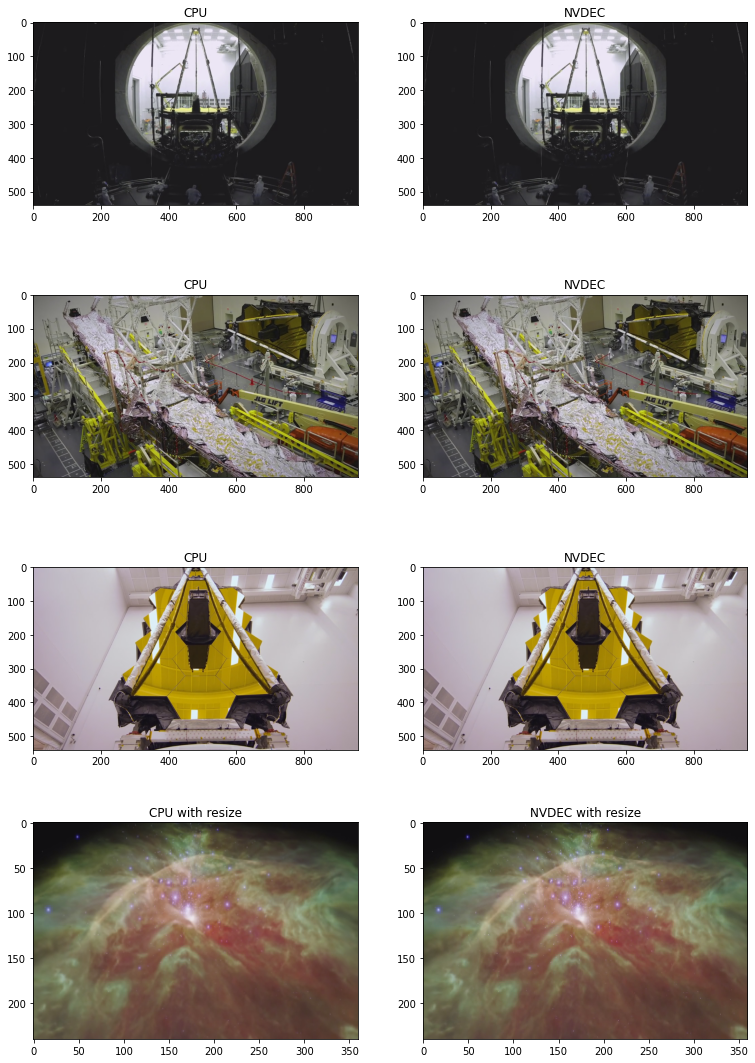

In [40]:
f, axs = plt.subplots(4, 2, figsize=[12.8, 19.2])
for i in range(4):
  for j in range(2):
    axs[i][j].imshow(yuv_to_rgb(samples[i][j]))
    axs[i][j].set_title(
        f"{'CPU' if j == 0 else 'NVDEC'}{' with resize' if i == 3 else ''}")
plt.plot(block=False)

## Benchmark NVENC with `StreamWriter`

Next, we benchmark encoding speed with StreamWriter and NVENC.



In [41]:
def test_encode(data, dst, **config):
  print("=" * 40)
  print("* Configuration:", config)
  print("* Destination:", dst)
  print("=" * 40)

  s = StreamWriter(dst)
  s.add_video_stream(**config)

  t0 = time.monotonic()
  with s.open():
    s.write_video_chunk(0, data)
  elapsed = time.monotonic() - t0

  print()
  print(f" - Processed {len(data)} frames.")
  print(f" - Elapsed: {elapsed} seconds.")
  print()
  return elapsed

result = torch.zeros((3, 3))

We use ``StreamReader`` to generate test data.

In [42]:
def get_data(frame_rate, height, width, format, duration=15):
  src = f"testsrc2=rate={frame_rate}:size={width}x{height}:duration={duration}"
  s = StreamReader(src=src, format="lavfi")
  s.add_basic_video_stream(-1, format=format)
  s.process_all_packets()
  video, = s.pop_chunks()
  return video

### Encode MP4 - 360P

For the first test, we compare the time it takes for CPU and NVENC to encode 15 seconds of video with small resolution.

In [43]:
pict_config = {
    "height": 360,
    "width": 640,
    "frame_rate": 30000/1001,
    "format": "yuv444p",
}

video = get_data(**pict_config)

#### CPU

In [44]:
encode_config = {
    "encoder": "libx264",
    "encoder_format": "yuv444p",
}

result[0, 0] = test_encode(video, "360p_cpu.mp4", **pict_config, **encode_config)

* Configuration: {'height': 360, 'width': 640, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'libx264', 'encoder_format': 'yuv444p'}
* Destination: 360p_cpu.mp4

 - Processed 450 frames.
 - Elapsed: 3.280829835000077 seconds.



#### CUDA (from CPU Tensor)

Now we test NVENC. This time, the data is sent from CPU memory to GPU memory as part of encoding.

In [45]:
encode_config = {
    "encoder": "h264_nvenc",  # Use NVENC
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},  # Run encoding on the cuda:0 device
}

result[1, 0] = test_encode(video, "360p_cuda.mp4", **pict_config, **encode_config)

* Configuration: {'height': 360, 'width': 640, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}}
* Destination: 360p_cuda.mp4

 - Processed 450 frames.
 - Elapsed: 0.34294435300000714 seconds.



#### CUDA (from CUDA Tensor)

If the data is already present on CUDA, then we can pass it to GPU encoder directly.

In [46]:
device = "cuda:0"

encode_config = {
    "encoder": "h264_nvenc",  # GPU Encoder
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},  # Run encoding on the cuda:0 device
    "hw_accel": device,  # Data comes from cuda:0 device
}

result[2, 0] = test_encode(video.to(torch.device(device)), "360p_cuda_hw.mp4", **pict_config, **encode_config)

* Configuration: {'height': 360, 'width': 640, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}, 'hw_accel': 'cuda:0'}
* Destination: 360p_cuda_hw.mp4

 - Processed 450 frames.
 - Elapsed: 0.2424524550000342 seconds.



### Encode MP4 - 720P

Let's run the same tests on video with larger resolution.

In [47]:
pict_config = {
    "height": 720,
    "width": 1280,
    "frame_rate": 30000/1001,
    "format": "yuv444p",
}

video = get_data(**pict_config)

#### CPU

In [48]:
encode_config = {
    "encoder": "libx264",
    "encoder_format": "yuv444p",
}

result[0, 1] = test_encode(video, "720p_cpu.mp4", **pict_config, **encode_config)

* Configuration: {'height': 720, 'width': 1280, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'libx264', 'encoder_format': 'yuv444p'}
* Destination: 720p_cpu.mp4

 - Processed 450 frames.
 - Elapsed: 11.638768525999922 seconds.



#### CUDA (from CPU Tensor)

In [49]:
encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
}

result[1, 1] = test_encode(video, "720p_cuda.mp4", **pict_config, **encode_config)

* Configuration: {'height': 720, 'width': 1280, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p'}
* Destination: 720p_cuda.mp4

 - Processed 450 frames.
 - Elapsed: 0.8508033889999069 seconds.



#### CUDA (from CUDA Tensor)

In [50]:
device = "cuda:0"

encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},
    "hw_accel": device,
}

result[2, 1] = test_encode(video.to(torch.device(device)), "720p_cuda_hw.mp4", **pict_config, **encode_config)

* Configuration: {'height': 720, 'width': 1280, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}, 'hw_accel': 'cuda:0'}
* Destination: 720p_cuda_hw.mp4

 - Processed 450 frames.
 - Elapsed: 0.6384492569999338 seconds.



### Encode MP4 - 1080P

We make the video with even larger.

In [51]:
pict_config = {
    "height": 1080,
    "width": 1920,
    "frame_rate": 30000/1001,
    "format": "yuv444p",
}

video = get_data(**pict_config)

#### CPU

In [52]:
encode_config = {
    "encoder": "libx264",
    "encoder_format": "yuv444p",
}

result[0, 2] = test_encode(video, "1080p_cpu.mp4", **pict_config, **encode_config)

* Configuration: {'height': 1080, 'width': 1920, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'libx264', 'encoder_format': 'yuv444p'}
* Destination: 1080p_cpu.mp4

 - Processed 450 frames.
 - Elapsed: 27.020421489 seconds.



#### CUDA (from CPU Tensor)

In [53]:
encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
}

result[1, 2] = test_encode(video, "1080p_cuda.mp4", **pict_config, **encode_config)

* Configuration: {'height': 1080, 'width': 1920, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p'}
* Destination: 1080p_cuda.mp4

 - Processed 450 frames.
 - Elapsed: 1.60377999800005 seconds.



#### CUDA (from CUDA Tensor)

In [54]:
device = "cuda:0"

encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},
    "hw_accel": device,
}

result[2, 2] = test_encode(video.to(torch.device(device)), "1080p_cuda_hw.mp4", **pict_config, **encode_config)

* Configuration: {'height': 1080, 'width': 1920, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}, 'hw_accel': 'cuda:0'}
* Destination: 1080p_cuda_hw.mp4

 - Processed 450 frames.
 - Elapsed: 1.4101193979998925 seconds.



### Result

Here is the result.

In [55]:
labels = ["CPU", "CUDA (from CPU Tensor)", "CUDA (from CUDA Tensor)"]
columns = ["360P", "720P", "1080P"]
res = pd.DataFrame(
    result.numpy(),
    index=labels,
    columns=columns,
)
print(res)

                             360P       720P      1080P
CPU                      3.280830  11.638768  27.020422
CUDA (from CPU Tensor)   0.342944   0.850803   1.603780
CUDA (from CUDA Tensor)  0.242452   0.638449   1.410119


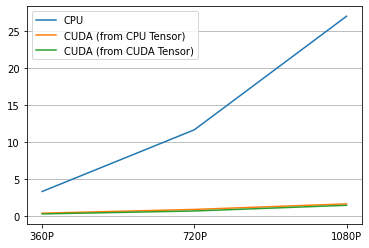

In [56]:
plt.plot(result.T)
plt.legend(labels)
plt.xticks([i for i in range(3)], columns)
plt.grid(visible=True, axis='y')

The resulting videos look like the following.

In [61]:
from IPython.display import HTML

HTML('''
<div>
  <video width=360 controls autoplay>
    <source src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter_360p_cpu.mp4" type="video/mp4">
  </video>
  <video width=360 controls autoplay>
    <source src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter_360p_cuda.mp4" type="video/mp4">
  </video>
  <video width=360 controls autoplay>
    <source src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter_360p_cuda_hw.mp4" type="video/mp4">
  </video>
</div>
''')

## Conclusion

We looked at how to build FFmpeg libraries with NVDEC/NVENC support and use them from TorchAudio. NVDEC/NVENC provide significant speed up when saving/loading a video.